In [1]:
!pip install "numpy==2.1.3" "matplotlib==3.9.2" "seaborn==0.13.2" "tqdm==4.67.1"

  Using cached numpy-2.1.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.0.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached numpy-2.1.3-cp312-cp312-macosx_14_0_arm64.whl (5.1 MB)
Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_a

In [2]:
import typing
import pathlib
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
random.seed(123456789)

In [4]:
def minmaxnorm(x, min_=0.0, max_=1.0):
    x = np.asarray(x)
    minx = min(x)
    maxx = max(x)
    std = (x - minx) / (maxx - minx)
    return std * (max_ - min_) + min_

In [5]:
def parse_datafile(datafile: typing.TextIO):
    """
    Returns: a pair of features and their corresponding target value
    Example:
        3 4
        0 389.05 133.34 62.14 32.60
        0 324.10 185.78 53.32 42.18
        1 438.88 161.21 88.47 51.06
    """
    header = datafile.readline().strip()
    n_instances, n_features = map(int, map(str.strip, header.split(" ")))
    lines = [datafile.readline().strip() for _ in range(n_instances)]
    X = []
    y = []
    for line in lines:
        values = [point for point in line.split(" ") if point.strip() != ""]
        y.append(int(values[0]))
        # mag_X = math.sqrt(sum(math.pow(float(x), 2) for x in values[1 : n_features + 1]))
        # X.append([float(x) / mag_X for x in values[1 : n_features + 1]])
        X.append(minmaxnorm([float(x) for x in values[1 : n_features + 1]])[:])
    return X, y

In [6]:
datafile = pathlib.Path.cwd().joinpath('data').joinpath('L30fft16.out')
with open(datafile) as f:
    X, y = parse_datafile(f)

In [7]:
class Neuron:
    def __init__(self, xy_loc: tuple[int, int], n: int, random_seed=None):
        rng = np.random.default_rng(random_seed)
        self.weights = rng.uniform(-1.0, 1.0, n)
        self.loc = xy_loc

In [8]:
def dist(V, X):
    """
    distance between two vectors in n space
    """
    return np.sqrt(np.sum(np.square(np.subtract(V, X))))

In [9]:
def distneurons(V1loc, V2loc, m):
    """
    distance between two neurons (wrap-around)
    """
    mx = my = math.sqrt(m)
    x1, y1 = V1loc
    x2, y2 = V2loc
    xdist = min(abs(x2-x1), abs((x2+mx)-x1), abs(x2-(x1+mx)))
    ydist = min(abs(y2-y1), abs((y2+my)-y1), abs(y2-(y1+my)))
    return np.sqrt(np.square(xdist) + np.square(ydist))

In [10]:
def r(t, T, maximum=1.0):
    return maximum * np.exp(-t/T)

Radial Basis Function (RBF)
$$
\phi_{\epsilon}(r) = e^{-\epsilon (r)^2}
$$

In [11]:
def rbf(r, epsilon):
    return np.exp(-epsilon * np.power(r, 2))

$$
d(V, X, r) = 2 e^{-r\text{dist}(V, X)^2}~~~~~~\text{where}~~~0 < r < \text{max}
$$

In [12]:
def rbfdist(V, X, r):
    return 2 * rbf(dist(V, X), epsilon=r)
    # return rbf(dist(V, X), epsilon=r)

neighborhood strength

$$
d(V_1, V_2, t) = e^{-\frac{t}{T} \times dist(V_1, V_2)^2}
$$

In [13]:
def neighborhoodstrength(V1, V2, t, T, m):
    sigma = 1 / (2 * np.log(2))
    return rbf(distneurons(V1.loc, V2.loc, m=m), epsilon=sigma * t/T)

adaptive learning rate
$$
\eta = \alpha e^{-2\frac{t}{T}}
$$

In [14]:
def eta(t, initial_learning_rate, T):
    return initial_learning_rate * np.exp(-2 * t / T)

In [15]:
def bmu(x, neurons):
    return min(neurons, key=lambda node: dist(node.weights, x))

In [16]:
class SOM:
    def __init__(self, n, m, random_seed=None):
        row_size = int(math.sqrt(m))
        self.n = n
        self.m = m
        self.rng = np.random.default_rng(random_seed)
        self.nodes = [Neuron(divmod(k, row_size), n=n, random_seed=self.rng) for k in range(m)]

    def train(self, X, L, T):
        l_rate = L
        progress = tqdm(range(T * len(X)))
        for t in range(T):
            xs = np.copy(X)
            self.rng.shuffle(xs)
            for x in xs:
                # Choose a random vector x
                # Find the closest v to x
                v0 = bmu(x, self.nodes)
                # move v0 closer to x by some factor
                delta_v0 = eta(t, l_rate, T) * rbfdist(v0.weights, x, r(t, T=T))
                v0.weights = np.subtract(v0.weights, delta_v0)
                # update all v based on neighbourhood update function
                for v in self.nodes:
                    if v != v0:
                        delta_v = eta(t, l_rate, T) * neighborhoodstrength(v0, v, t, T=T, m=self.m)
                        v.weights -= delta_v * np.subtract(v.weights, x)
            progress.update(len(X))
        return self    

    def classify(self, X, Y):
        maps = {(node.loc): 0.0 for node in self.nodes}
        for x, y in zip(X, Y):
            v0 = bmu(x, self.nodes)
            for v in self.nodes:
                activation = neighborhoodstrength(v0, v, t=1, T=1, m=self.m)
                if y == 0:
                    maps[v.loc] += activation
                else:
                    maps[v.loc] -= activation
        return [maps[node.loc] for node in self.nodes]

In [17]:
M = 7*7 # number of V centroids
N = len(X[0]) # number of dimensions
T = 2000 # max number of time units

In [18]:
som = SOM(n=N, m=M, random_seed=123456789)
som.train(X, 1.0, T)

  0%|          | 0/106000 [00:00<?, ?it/s]

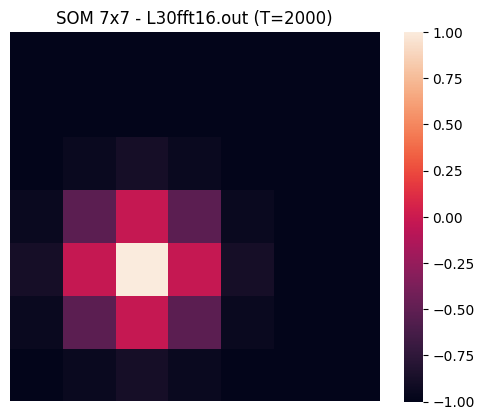

In [19]:
preds = minmaxnorm(som.classify(X, y), min_=-1.0, max_=1.0) # scale to [-1.0, 1.0]
heatmap = np.empty((int(math.sqrt(len(som.nodes))), int(math.sqrt(len(som.nodes)))))
for node, pred in zip(som.nodes, preds):
    heatmap[int(node.loc[0]), int(node.loc[1])] = pred

sns.heatmap(heatmap, square=True)

row_size = int(math.sqrt(M))
plt.title(f"SOM {row_size}x{row_size} - {datafile.name} (T={T})")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# plt.savefig(f"tmp/heatmap-{row_size}x{row_size}-{datafile.stem}.png")
plt.show()